### Import Data & libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
reves = pd.read_pickle("data/reves.pkl")

In [3]:
reves.head()

,directors,writers,belongs_to_collection,genres,homepage,original_language,production_companies,runtime,keywords,release_month,release_weekday,cast_names,revenue_inflated,production_companies_counter,N_male,N_female
0,2.669624e+08,2.669624e+08,7.092380e+07,1.059860e+08,7.941297e+07,1.188783e+08,2.669624e+08,193.0,2.269225e+08,8.272077e+07,1.408839e+08,1.759860e+08,2.669624e+08,1,1,3
1,1.799046e+08,1.962946e+08,7.092380e+07,1.667151e+08,7.941297e+07,1.188783e+08,1.799046e+08,105.0,1.175707e+08,1.797448e+08,9.058722e+07,1.799046e+08,1.799046e+08,1,0,0
2,1.298649e+08,1.298649e+08,7.092380e+07,8.279268e+07,7.941297e+07,1.188783e+08,1.298649e+08,93.0,2.149132e+08,8.251373e+07,1.279176e+08,1.468606e+08,1.298649e+08,1,1,1
3,7.112113e+07,7.112113e+07,7.092380e+07,8.279268e+07,7.941297e+07,1.188783e+08,4.454915e+07,68.0,1.225954e+08,5.521710e+07,8.316584e+07,4.069436e+07,3.423464e+07,2,2,1
4,2.919561e+06,4.166173e+06,7.092380e+07,7.353105e+07,7.941297e+07,1.188783e+08,5.839109e+06,117.0,5.842999e+07,5.521710e+07,1.691554e+08,1.052070e+07,5.839109e+06,1,1,0


In [4]:
reves.columns

Index(['directors', 'writers', 'belongs_to_collection', 'genres', 'homepage',
       'original_language', 'production_companies', 'runtime', 'keywords',
       'release_month', 'release_weekday', 'cast_names', 'revenue_inflated',
       'production_companies_counter', 'N_male', 'N_female'],
      dtype='object')

In [5]:
y = reves["revenue_inflated"].values
y.shape

(6441,)

In [6]:
train = reves.drop(["revenue_inflated"], axis = 1)

In [7]:
X = train.values
X.shape

(6441, 15)

### Modelling. 

Explicación del modelo y por qué lo hemos elegido. 
Creacion estructura del modelo (variables, metricas, etc). 

In [8]:
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### Creación de la Función para aplicar modelo

Creamos la función y para que se vea lo que hace y las variables que devuelve. 

Explicar que para probar diferentes versiones vamos a usar las mtricas rmse y mae, y que gridsearchCv lo utilizaremos en el modelo final para explicar cómo funciona pero no ralentizar el notebook ejecutando un gridsearch en cada una de las versiones.

42903550.3527


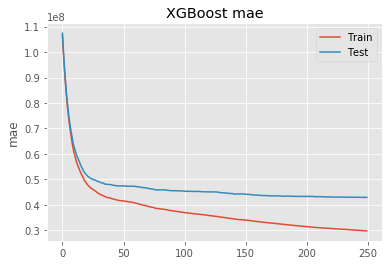

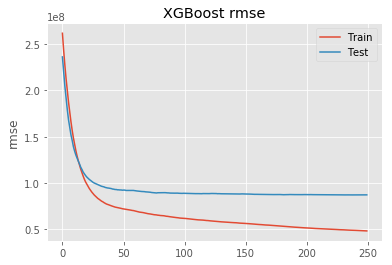

In [10]:
xgbo = XGBRegressor(n_estimators = 250, max_depth = 3)

eval_set = [(X_train, y_train), (X_test, y_test)]
xgbo.fit(X_train, y_train, eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = xgbo.predict(X_test)

# evaluate predictions
error = mean_absolute_error(y_test, y_pred)
print(error)

# retrieve performance metrics
results = xgbo.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot mae
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('mae')
plt.title('XGBoost mae')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost rmse')
plt.show()

##### Versión 1. Usando todas las variables

introduces los datos
aplicas la funcion
sacas la grafica
explicas resultados
guardas resultados como variable.

#### Versión 2. Usando solo....

####   Comparativa de modelos.
Sacar tabla con todos los resultados que hemos ido generando, y comentario/explciación final y elegir 1.

### Modelo final

- GridsearchCv para explicar cuáles son los parametros optimos que utiliza el modelo
- Entrenar con todos los datos y guardar pkl
- Gráficas finales de importancias de las variables

In [11]:
predictions = xgbo.predict(X_test)
variance_score = explained_variance_score(predictions,y_test)

In [12]:
score = xgbo.score(X_test,y_test)

In [13]:
cross_val = cross_val_score(xgbo, X, y, cv = 10).mean()
cross_val

0.78604283095521332

In [14]:
from xgboost import plot_importance

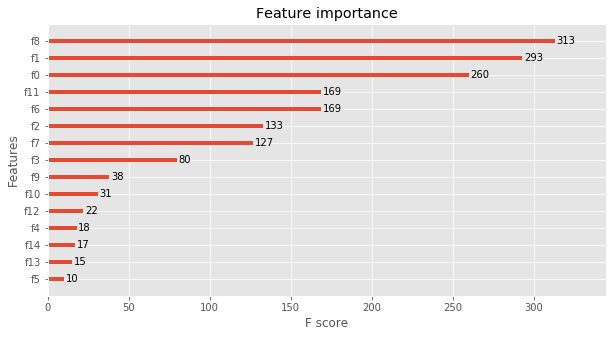

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgbo, ax = ax, importance_type="weight")
plt.show()

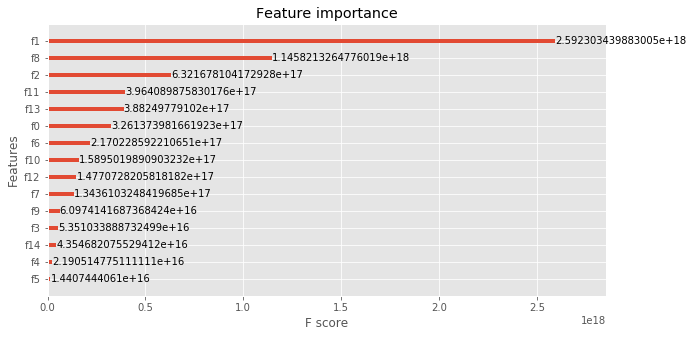

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgbo, ax = ax, importance_type="gain")
plt.show()

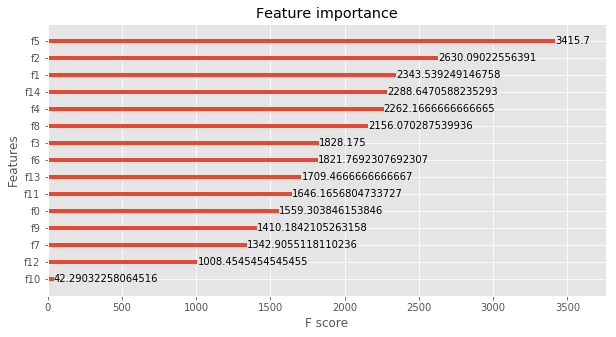

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgbo, ax = ax, importance_type="cover")
plt.show()

### Results

Estas dos celdas de aquí abajo son el código que he utilizado para ir probando el modelo con diferentes variables para ver como iba cambiando, si había variables que igual eran mejor quitar o dejar. Los resultados están guardados en un DataFrame y más abajo lo cargo y lo leo para que se puedan ver como fueron estos resultados.

In [18]:
# experiment = "No Homepage and men"
# number_experiment = 14
# row = [experiment, error, variance_score, score, cross_val]

In [19]:
# xgbo_results = pd.DataFrame(columns = ["experiment", "mean_absolute_error", "explained_variance_score", "score", "cross_val_score"])
# xgbo_results.loc[number_experiment] = row
# xgbo_results.to_pickle("data/xgbo_results.pkl")

In [20]:
xgbo_results = pd.read_pickle("data/xgbo_results.pkl")

In [21]:
xgbo_results

,experiment,mean_absolute_error,explained_variance_score,score,cross_val_score
0,All Features,4.290355e+07,0.814659,0.851043,0.786043
1,No Homepage,4.269775e+07,0.811079,0.850308,0.782925
2,No writers,4.719237e+07,0.782957,0.834650,0.785542
3,No original language,4.290729e+07,0.812264,0.849592,0.785689
4,No release weekday,4.311008e+07,0.808759,0.846390,0.781085
5,No release month,4.280380e+07,0.816304,0.852942,0.781749
6,No production companies counter,4.325453e+07,0.802839,0.844029,0.788444
7,No Number of Men,4.205137e+07,0.827326,0.859252,0.784009
8,No Number of Women,4.287313e+07,0.812704,0.849600,0.786124
9,No Number of Men and Women,4.238165e+07,0.830525,0.861316,0.780882


## Final Model

Escojo el modelo que no cuenta el número de hombres en los 4 papeles principales

In [22]:
y = reves["revenue_inflated"].values
X = reves.drop(["revenue_inflated", "N_male"], axis = 1).values

In [23]:
xgbo = XGBRegressor(n_estimators = 250, max_depth = 3)
xgbo.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Guardo el modelo en un archivo pickle

In [24]:
import pickle
pickle.dump(xgbo, open("xgbo_model.pkl", "wb"))